Goal: This script uses [this](https://github.com/arvindkrishna87/STAT390_WI2025/blob/a90ac97e593db9953ff84f22a33382476c8faeb6/Presentation%205/Coders/Nathan%20Jung/CNN%20model.ipynb) CNN model made last quarter by Nathan and evaluates how the model performs on different image sizes

Author: David Gormley

Last Modified: 5/5/25

Structure

1) Import Dependencies and mount drive

2) Train Model

3) Evaluate Model

4) Exploring Performance by Case

5) Tackling Class Imbalance

Key Issue
- Folder is missing some of the cases that Krish identified as good cases
    - Here are the cases Krish identified as good
      - train_cases  = [2,1,22,9,34,38,53,55,78,62,85,89,21,3,45,49]
      - test_cases   = [77,60,79,70,90,92,25,12]

    - Here are the cases that we actually have
      - true_train = [1,2,3,9,53,55,78,85,89]
      - true_test = [12,60,77,79,90,92]



**1) Import Dependencies and mount drive**

In [ ]:
# stdlib
import os
import glob
import re
import struct
from concurrent.futures import ThreadPoolExecutor, as_completed

# data & imaging
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision import transforms

# metrics & plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Colab
from google.colab import drive

In [ ]:
# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)

# ─── 2) DEVICE & CUDNN ──────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True  # auto‐tune for fixed input sizes

Mounted at /content/drive


**2. Train Model**
- We can adjust the following
    - Restricting image size: min and max image width used for training and evaluation
    - Stain type
    - Train and test cases

In [ ]:
# ─── 1) CONFIG ──────────────────────────────────────────────────────────
image_folder = "/content/drive/MyDrive/'25 Spring/390/CMIL_SP2025_Patches_Apr16"
train_cases  = [2,1,22,9,34,38,53,55,78,62,85,89,21,3,45,49]
test_cases   = [77,60,79,70,90,92,25,12]
batch_size   = 64
num_workers  = 4
lr           = 1e-3
num_epochs   = 10
stains       = ['h&e']               # adjust list as needed
min_width    = 256
max_width    = 512
meta_csv     = '/content/drive/MyDrive/patch_metadata.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 2) LABEL CSV & MAP ─────────────────────────────────────────────────
labels_df = pd.read_csv(
    "/content/drive/MyDrive/'25 Spring/390/case_grade_match.csv"
).drop(index=64, errors='ignore').reset_index(drop=True)
class_map = {int(r.Case): (0 if r.Class == 1 else 1) for _, r in labels_df.iterrows()}

# ─── 3) METADATA BUILD/LOAD ──────────────────────────────────────────────
def build_metadata():
    if os.path.exists(meta_csv):
        return pd.read_csv(meta_csv)
    # gather all files
    all_files = [os.path.join(dp, f)
                 for dp, _, fs in os.walk(image_folder)
                 for f in fs if f.lower().endswith('.png')]

    def process(p):
        basename = os.path.basename(p)
        cid_m    = re.search(r'case_(\d+)_', basename, re.IGNORECASE)
        if not cid_m:
            return None
        cid = int(cid_m.group(1))
        # case filter
        if cid not in set(train_cases + test_cases):
            return None
        # stain filter
        name_low = basename.lower()
        stain = next((s for s in stains if s in name_low), None)
        if not stain:
            return None
        # header parse
        try:
            with open(p, 'rb') as f:
                hdr = f.read(24)
            w = struct.unpack('>I', hdr[16:20])[0]
            h = struct.unpack('>I', hdr[20:24])[0]
        except:
            return None
        label = class_map.get(cid)
        return {'path': p, 'case_number': cid, 'stain': stain,
                'width': w, 'height': h, 'label': label}

    with ThreadPoolExecutor(max_workers=8) as exe:
        results = list(exe.map(process, all_files))
    df_meta = pd.DataFrame([r for r in results if r])
    df_meta.to_csv(meta_csv, index=False)
    return df_meta

df_meta = build_metadata()

# ─── 4) FILTER FOR TRAIN/TEST ────────────────────────────────────────────
def filter_meta(df, cases):
    df2 = df[df.case_number.isin(cases)]
    df2 = df2[(df2.width > min_width) & (df2.width < max_width)]
    df2 = df2[df2.stain.isin(stains)]
    return df2

df_train = filter_meta(df_meta, train_cases)
df_test  = filter_meta(df_meta, test_cases)

train_paths = df_train['path'].tolist()
test_paths  = df_test['path'].tolist()

# ─── 5) TRANSFORMS & DATASETS ─────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class CaseDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert('RGB')
        if self.transform: img = self.transform(img)
        cid = int(re.search(r'case_(\d+)_', os.path.basename(p), re.IGNORECASE).group(1))
        lbl = class_map[cid]
        return img, lbl

train_ds = CaseDataset(train_paths, transform=train_transform)
test_ds  = CaseDataset(test_paths,  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)

# ─── 6) MODEL SETUP ──────────────────────────────────────────────────────
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters(): param.requires_grad=False
in_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=lr)
scaler = torch.cuda.amp.GradScaler()

# ─── 7) TRAIN LOOP ───────────────────────────────────────────────────────
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}', leave=False)
    for imgs, lbls in pbar:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): outputs = model(imgs); loss = criterion(outputs, lbls)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running += loss.item()*lbls.size(0)
        pbar.set_postfix(loss=running/((pbar.n+1)*batch_size))
    print(f'Epoch {epoch}: Train Loss = {running/len(train_ds):.4f}')

# ─── 8) EVALUATION ───────────────────────────────────────────────────────
model.eval(); correct=total=0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(1)
        correct += (preds==lbls).sum().item(); total += lbls.size(0)
print(f'Test Accuracy: {100*correct/total:.2f}%')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNe

Epoch 1/10:   0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-3-124d88eecb6a>:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(imgs); loss = criterion(outputs, lbls)


Epoch 1: Train Loss = 0.8087


Epoch 2/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.6086


Epoch 3/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.3720


Epoch 4/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.2214


Epoch 5/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.1603


Epoch 6/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.1381


Epoch 7/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.1192


Epoch 8/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.1484


Epoch 9/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.0935


Epoch 10/10:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.0904
Test Accuracy: 87.36%


**3) Evaluate Model**

In [ ]:
# ─── 9) PATCH‐LEVEL EVALUATION ───────────────────────────────────────────
model.eval()
all_preds, all_labels = [], []
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = (images.to(device, non_blocking=True),
                          labels.to(device, non_blocking=True))
        outputs = model(images)
        preds   = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

accuracy  = 100 * correct / total
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)

print(f"Test Patch‐level Accuracy : {accuracy:.2f}%")
print(f"Precision                : {precision:.4f}")
print(f"Recall                   : {recall:.4f}")
print(f"F1 Score                 : {f1:.4f}")

Test Patch‐level Accuracy : 87.36%
Precision                : 0.2308
Recall                   : 0.7500
F1 Score                 : 0.3529


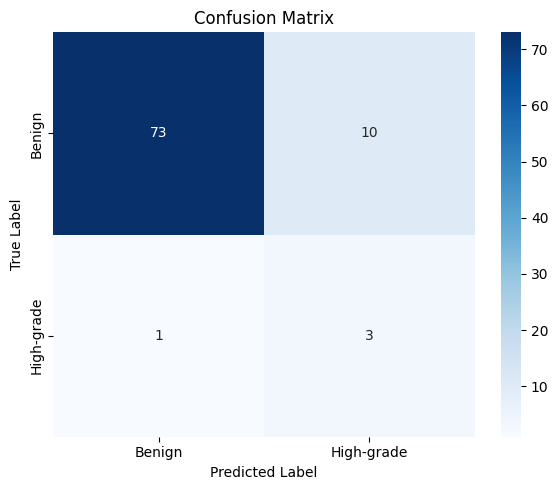

In [ ]:
# ─── CONFUSION MATRIX ────────────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
labels = ['Benign', 'High-grade']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

**4) Exploring Performance by Case**
- Use this code to evaluate how the model is doing at the case level

In [ ]:
# ─── (1) Update your Dataset ───────────────────────────────────────────────
class CaseDataset(Dataset):
    def __init__(self, paths, class_map, transform=None):
        self.paths     = paths
        self.class_map = class_map
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert('RGB')
        if self.transform:
            img = self.transform(img)

        basename = os.path.basename(p)
        case_id  = int(re.search(r"case_(\d+)_", basename, flags=re.IGNORECASE).group(1))
        label    = self.class_map[case_id]
        return img, label, case_id

# Re-instantiate your test dataset & loader:
test_ds = CaseDataset(test_paths, class_map, transform=test_transform)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, persistent_workers=True
)

# ─── (2) Patch-level evaluation collecting case_ids ──────────────────────
model.eval()
records = []
with torch.no_grad():
    for images, labels, case_ids in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        # move back to CPU and iterate
        for pred, true, cid in zip(preds.cpu().numpy(),
                                   labels.cpu().numpy(),
                                   case_ids.cpu().numpy()):
            records.append({
                'case_number': cid,
                'pred':        pred,
                'label':       true
            })

# ─── (3) Build DataFrame & compute per-case metrics ──────────────────────
df_eval = pd.DataFrame(records)

results = []
for case, group in df_eval.groupby('case_number'):
    y_true = group['label']
    y_pred = group['pred']
    results.append({
        'case_number': case,
        'n_patches':   len(group),
        'accuracy':    accuracy_score(y_true, y_pred),
        'precision':   precision_score(y_true, y_pred, zero_division=0),
        'recall':      recall_score(y_true, y_pred, zero_division=0),
        'f1_score':    f1_score(y_true, y_pred, zero_division=0),
    })

df_results = pd.DataFrame(results).sort_values('case_number').reset_index(drop=True)
print(df_results)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


   case_number  n_patches  accuracy  precision    recall  f1_score
0           12        102  1.000000        1.0  1.000000  1.000000
1           60         25  0.120000        1.0  0.120000  0.214286
2           77         83  0.939759        0.0  0.000000  0.000000
3           79        384  0.927083        0.0  0.000000  0.000000
4           90        102  0.960784        0.0  0.000000  0.000000
5           92        161  0.826087        1.0  0.826087  0.904762


In [ ]:
test_cases   = [77,60,79,70,90,92, 25,12,45,49]
missing = [70,25,45,49]

np.int64(706)

ALERT: Why does case 70 not exist?

**5) Tackling Class Imbalance**
- Rerunning analysis with loss weighting and weighted sampler

In [ ]:
import os, re, struct
import numpy as np
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms
from tqdm import tqdm

# ─── 1) CONFIG ──────────────────────────────────────────────────────────
image_folder = "/content/drive/MyDrive/'25 Spring/390/CMIL_SP2025_Patches_Apr16"
train_cases  = [2,1,22,9,34,38,53,55,78,62,85,89,21,3,25,12,45,49]
test_cases   = [77,60,79,70,90,92,25,12,45,49]
batch_size   = 64
num_workers  = 4
lr           = 1e-3
num_epochs   = 4
stains       = ['h&e']
min_width    = 215
max_width    = 1000
meta_csv     = '/content/drive/MyDrive/patch_metadata.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 2) LABEL CSV & MAP ─────────────────────────────────────────────────
labels_df = pd.read_csv("/content/drive/MyDrive/'25 Spring/390/case_grade_match.csv") \
              .drop(index=64, errors='ignore').reset_index(drop=True)
class_map = {int(r.Case): (0 if r.Class == 1 else 1) for _, r in labels_df.iterrows()}

# ─── 3) METADATA BUILD/LOAD ──────────────────────────────────────────────
def build_metadata():
    if os.path.exists(meta_csv):
        return pd.read_csv(meta_csv)
    all_files = [os.path.join(dp, f)
                 for dp, _, fs in os.walk(image_folder)
                 for f in fs if f.lower().endswith('.png')]

    def process(p):
        basename = os.path.basename(p)
        m = re.search(r'case_(\d+)_', basename, re.IGNORECASE)
        if not m: return None
        cid = int(m.group(1))
        if cid not in set(train_cases + test_cases): return None
        stain = next((s for s in stains if s in basename.lower()), None)
        if not stain: return None
        try:
            with open(p, 'rb') as f: hdr = f.read(24)
            w = struct.unpack('>I', hdr[16:20])[0]
            h = struct.unpack('>I', hdr[20:24])[0]
        except:
            return None
        label = class_map.get(cid)
        return {'path': p, 'case_number': cid, 'stain': stain,
                'width': w, 'height': h, 'label': label}

    with ThreadPoolExecutor(max_workers=8) as exe:
        results = list(exe.map(process, all_files))
    df = pd.DataFrame([r for r in results if r])
    df.to_csv(meta_csv, index=False)
    return df

df_meta = build_metadata()

# ─── 4) FILTER FOR TRAIN/TEST ────────────────────────────────────────────
def filter_meta(df, cases):
    df2 = df[df.case_number.isin(cases)]
    df2 = df2[(df2.width > min_width) & (df2.width < max_width)]
    df2 = df2[df2.stain.isin(stains)]
    return df2

df_train = filter_meta(df_meta, train_cases)
df_test  = filter_meta(df_meta, test_cases)

# ─── sampler & class weights ─────────────────────────────────────────────
train_labels = df_train['label'].values
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# ─── 5) TRANSFORMS & DATASETS ─────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class CaseDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert('RGB')
        if self.transform: img = self.transform(img)
        cid = int(re.search(r'case_(\d+)_', os.path.basename(p), re.IGNORECASE).group(1))
        lbl = class_map[cid]
        return img, lbl

train_ds = CaseDataset(df_train['path'].tolist(), transform=train_transform)
test_ds  = CaseDataset(df_test['path'].tolist(),  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)

# ─── 6) MODEL SETUP ──────────────────────────────────────────────────────
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_ftrs, 2)
model = model.to(device)

cw = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw)
optimizer = optim.Adam(model.classifier[6].parameters(), lr=lr)
scaler = torch.cuda.amp.GradScaler()

# ─── 7) TRAIN LOOP ───────────────────────────────────────────────────────
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}', leave=False)
    for imgs, lbls in pbar:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item()*lbls.size(0)
        pbar.set_postfix(loss=running/((pbar.n+1)*batch_size))
    print(f'Epoch {epoch}: Train Loss = {running/len(train_ds):.4f}')

# ─── 8) EVALUATION ───────────────────────────────────────────────────────
model.eval()
correct = total = 0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(1)
        correct += (preds==lbls).sum().item()
        total += lbls.size(0)
print(f'Test Accuracy: {100*correct/total:.2f}%')


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNe

Epoch 1: Train Loss = 0.5718


Epoch 2: Train Loss = 0.1884


Epoch 3: Train Loss = 0.1593


Epoch 4: Train Loss = 0.1445


Test Accuracy: 82.42%
